import the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager

import matplotlib.gridspec as gridspec
from urllib.request import urlopen
import time
import requests
import bs4 as bs
import urllib.request

we make the necessary fonts available

In [2]:
font_manager.fontManager.addfont('/Users/arpadambrusz/Desktop/jupyter_work/fonts/Rajdhani/Rajdhani-Medium.ttf')
font_manager.fontManager.addfont('/Users/arpadambrusz/Desktop/jupyter_work/fonts/Kdam_Thmor_Pro/KdamThmorPro-Regular.ttf')
font_manager.fontManager.addfont('/Users/arpadambrusz/Desktop/jupyter_work/fonts/Canonatia.ttf')

make some aesthetic adjustments

In [3]:
plt.rcParams['font.family'] = 'Rajdhani'
plt.rcParams['font.size'] = 11.0
plt.rcParams['ytick.labelsize']  = 12.5
plt.rcParams['ytick.minor.left'] = False

we write a function to get the necessary data - the preliminary check revealed that we need to write a few extra lines

In [6]:
def season_NB2(lastroundNumber):
    start = time.time()
    
    hj = []
    
    for num in range(1,lastroundNumber+1):
        #-------------------------------------------
        # here we had a problem
        if num == 9:
            url = f'https://adatbank.mlsz.hu/league/54/0/22650/{num}.html'

            r = requests.get(url)
            soup = bs.BeautifulSoup(r.content, "html.parser")

            tuPP = [(num, x.text.strip().split('\n')[0], x.text.strip().split('\n')[4], x.text.strip().split('\n')[2].split('-')[0],x.text.strip().split('\n')[2].split('-')[1]) for \
                idx, x in enumerate(soup.find_all('div',{'class':'schedule'})) if idx<10 and idx != 7]
            
            tuPP.append((9, 'SZEGED-CSANÁD GROSICS AKADÉMIA', 'GYIRMÓT FC GYŐR', '0 ', ' 1'))
            hj = hj+tuPP
            
        if num !=9:
            
            url = f'https://adatbank.mlsz.hu/league/54/0/22650/{num}.html'

            r = requests.get(url)
            soup = bs.BeautifulSoup(r.content, "html.parser")

            tuPP = [(num, x.text.strip().split('\n')[0], x.text.strip().split('\n')[4], x.text.strip().split('\n')[2].split('-')[0],x.text.strip().split('\n')[2].split('-')[1]) for \
                idx, x in enumerate(soup.find_all('div',{'class':'schedule'})) if idx<10]

            hj = hj+tuPP
            
    end = time.time() 
    
    print(f'It lasted {round(end-start,2)} seconds\nDONE')
    return hj

In [7]:
df_2020_21 = season_NB2(38)

It lasted 31.61 seconds
DONE


we disassemble and organize the data

In [9]:
def dataSorting(dataFrame):
    start = time.time()
    
    home,away,HG,AG = [],[],[],[]

    for row in dataFrame:
        home.append(row[1])
        away.append(row[2])
        HG.append(int(row[3]))
        AG.append(int(row[4]))

    df_2021 = pd.DataFrame({'HT':home,'AT':away,'HG':HG,'AG':AG})
    
    end = time.time() 
    print(f'It lasted {round(end-start,2)} seconds\nDONE')
    return df_2021

In [11]:
df = dataSorting(df_2020_21)

It lasted 0.0 seconds
DONE


In [12]:
df.head()

,HT,AT,HG,AG
0,KAPOSVÁRI RÁKÓCZI FC,NYÍREGYHÁZA SPARTACUS FC,0,1
1,SOROKSÁR SC,DEAC,1,0
2,DVSC,BUDAÖRS,1,0
3,PMFC,DOROGI FC,4,0
4,FC AJKA,WKW ETO FC GYŐR,2,1


Next step: from the results in the table above, we determine the points earned by the teams, winners, etc.

In [13]:
df_2021 = (df
    .assign(res=np.where(df.HG>df.AG,1,np.where(df.HG<df.AG,2,0)))
)

df_2021 = (df_2021
    .assign(
           mp = 1,
           hp =np.where(df_2021.res == 1, 3, np.where(df_2021.res==2,0,1)),
           ap =np.where(df_2021.res == 1, 0, np.where(df_2021.res==2,3,1)) )
    )

In [14]:
df_2021.head()

,HT,AT,HG,AG,res,mp,hp,ap
0,KAPOSVÁRI RÁKÓCZI FC,NYÍREGYHÁZA SPARTACUS FC,0,1,2,1,0,3
1,SOROKSÁR SC,DEAC,1,0,1,1,3,0
2,DVSC,BUDAÖRS,1,0,1,1,3,0
3,PMFC,DOROGI FC,4,0,1,1,3,0
4,FC AJKA,WKW ETO FC GYŐR,2,1,1,1,3,0


we will clean up the names of the teams a little

In [16]:
def teamNameChange(dataFrame):
    
    # arbitrary names - let's pay attention to the order
    teamsName = ['Csákvár','Siófok','Budaörs','Békéscsaba','DEAC','Dorog','Debrecen','Ajka','Gyirmót','Kaposvár','Kazincbarcika','Nyíregyháza','Pécsi MFC','Soroksár',
                 'Szeged','Szentlőrinc','Szolnok','Haladás','Vasas','ETO FC Győr']
    
    df_Name = pd.DataFrame({'old':sorted(list(dataFrame.HT.unique())),'new':teamsName})
    
    tt = [df_Name[df_Name.old == x].new.values[0] for x in dataFrame.HT] 
    at = [df_Name[df_Name.old == x].new.values[0] for x in dataFrame.AT] 
    
    dataFrame = (dataFrame
        .assign(HT = tt,
               AT=at))
    
    # arranged in the correct order 
    return dataFrame

In [17]:
df2021 = teamNameChange(df_2021)

In [18]:
df2021.head()

,HT,AT,HG,AG,res,mp,hp,ap
0,Kaposvár,Nyíregyháza,0,1,2,1,0,3
1,Soroksár,DEAC,1,0,1,1,3,0
2,Debrecen,Budaörs,1,0,1,1,3,0
3,Pécsi MFC,Dorog,4,0,1,1,3,0
4,Ajka,ETO FC Győr,2,1,1,1,3,0


In [40]:
def tableArrange(dataFrame):
    
    collect = {}
    
    for team in dataFrame.HT.unique():
        
        df_Team = dataFrame[(dataFrame.HT == team)|(dataFrame.AT == team)]    #team selection (home,away matches)
        
        df_Team = (df_Team
               .assign(Pont = [df_Team.iloc[x].hp if  df_Team.iloc[x].HT == team else df_Team.iloc[x].ap for x in range(len(df_Team))]))
        
        # points earned in 5 matches
        points_Per_5_matches = [sum(df_Team.iloc[x:x+5].Pont) for x in range(0,len(df_Team),5)]             
        #the ratio of the points that can be obtained and the points obtained - in 5 matches
        points_Ratio = [round(sum(df_Team.iloc[x:x+5].Pont)/(len(df_Team.iloc[x:x+5])*3),2) for x in range(0,len(df_Team),5)]   

        
        # data arrange (in dictionary) -> 
        collect[team] = [points_Per_5_matches,points_Ratio,np.sum(df_Team.Pont),round(np.sum(df_Team.Pont)/((len(df_Team))*3),3)]
    
    #------------------------------------------------------------------- LOOP IS END
    
    # put it data to dataFrame
    df_Middle = pd.DataFrame(collect).T.reset_index().rename(columns={'index':'team',0:'pontok',1:'pct',2:'fullP',3:'PontPct'})

    # we disassemble the data of the columns that are in the list - and we add new names for columns
    df_End = pd.concat([pd.concat([df_Middle,pd.DataFrame(df_Middle['pontok'].tolist())],axis=1)
                .rename(columns={0:'p/5',1:'p/10',2:'p/15',3:'p/20',4:'p/25',5:'p/30',6:'p/35',7:'p/38'}),pd.DataFrame(df_Middle['pct'].tolist())],axis=1).drop(['pontok','pct'],axis=1)\
                .rename(columns={0:'1/5',1:'5/10',2:'10/15',3:'15/20',4:'20/25',5:'25/30',6:'30/35',7:'35/38'}).sort_values(by='fullP',ascending=False).reset_index(drop=True)

    # last modification
    df_End['35/38'] = round(df_End['p/38']/9,2) 

    
    return df_End
    
    

In [41]:
df = tableArrange(df2021)

In [42]:
df

,team,fullP,PontPct,p/5,p/10,p/15,p/20,p/25,p/30,p/35,p/38,1/5,5/10,10/15,15/20,20/25,25/30,30/35,35/38
0,Debrecen,80,0.702,10,13,11,11,9,9,8,9,0.67,0.87,0.73,0.73,0.60,0.60,0.53,1.00
1,Gyirmót,78,0.684,12,10,7,6,12,9,13,9,0.80,0.67,0.47,0.40,0.80,0.60,0.87,1.00
2,Vasas,78,0.684,9,2,13,15,10,10,13,6,0.60,0.13,0.87,1.00,0.67,0.67,0.87,0.67
3,Pécsi MFC,64,0.561,8,5,13,13,8,8,5,4,0.53,0.33,0.87,0.87,0.53,0.53,0.33,0.44
4,Ajka,62,0.544,12,1,6,7,10,12,10,4,0.80,0.07,0.40,0.47,0.67,0.80,0.67,0.44
5,Budaörs,59,0.518,6,12,12,9,2,4,10,4,0.40,0.80,0.80,0.60,0.13,0.27,0.67,0.44
6,Szolnok,57,0.5,10,8,4,7,10,4,10,4,0.67,0.53,0.27,0.47,0.67,0.27,0.67,0.44
7,Soroksár,57,0.5,4,10,10,5,13,6,2,7,0.27,0.67,0.67,0.33,0.87,0.40,0.13,0.78
8,Nyíregyháza,57,0.5,10,9,5,4,8,11,4,6,0.67,0.60,0.33,0.27,0.53,0.73,0.27,0.67
9,Szeged,56,0.491,2,9,6,7,2,10,11,9,0.13,0.60,0.40,0.47,0.13,0.67,0.73,1.00


#little aesthetically modification - goal is highlighting the point

In [43]:
df.style.background_gradient(subset=["1/5",'5/10','10/15','15/20','20/25','25/30','30/35','35/38','PontPct'], cmap="RdYlGn", vmin=0, vmax=1)\
                                                                                                                                                        .set_properties(**{"border": "0.5px solid black"}).format(precision=3)

,team,fullP,PontPct,p/5,p/10,p/15,p/20,p/25,p/30,p/35,p/38,1/5,5/10,10/15,15/20,20/25,25/30,30/35,35/38
0,Debrecen,80,0.702,10,13,11,11,9,9,8,9,0.670,0.870,0.730,0.730,0.600,0.600,0.530,1.000
1,Gyirmót,78,0.684,12,10,7,6,12,9,13,9,0.800,0.670,0.470,0.400,0.800,0.600,0.870,1.000
2,Vasas,78,0.684,9,2,13,15,10,10,13,6,0.600,0.130,0.870,1.000,0.670,0.670,0.870,0.670
3,Pécsi MFC,64,0.561,8,5,13,13,8,8,5,4,0.530,0.330,0.870,0.870,0.530,0.530,0.330,0.440
4,Ajka,62,0.544,12,1,6,7,10,12,10,4,0.800,0.070,0.400,0.470,0.670,0.800,0.670,0.440
5,Budaörs,59,0.518,6,12,12,9,2,4,10,4,0.400,0.800,0.800,0.600,0.130,0.270,0.670,0.440
6,Szolnok,57,0.500,10,8,4,7,10,4,10,4,0.670,0.530,0.270,0.470,0.670,0.270,0.670,0.440
7,Soroksár,57,0.500,4,10,10,5,13,6,2,7,0.270,0.670,0.670,0.330,0.870,0.400,0.130,0.780
8,Nyíregyháza,57,0.500,10,9,5,4,8,11,4,6,0.670,0.600,0.330,0.270,0.530,0.730,0.270,0.670
9,Szeged,56,0.491,2,9,6,7,2,10,11,9,0.130,0.600,0.400,0.470,0.130,0.670,0.730,1.000


In [44]:
def ploTTing(dataFrame):
    
    fig = plt.figure()
    fig.set_figheight(13.5)
    fig.set_figwidth(19)
    
    #we make some aesthetic adjustments that we like
    
    plt.rcParams['axes.facecolor'] = '#efe9e6'
    plt.rcParams['figure.facecolor'] = '#efe9e6'
    signature = 'Canonatia'

    #you need this to define Plot locations
    counter = 0
    counter2 = 0

    for ind in range(20):
        
        num = plt.subplot2grid(shape=(5, 4), loc=(counter, counter2), colspan=1, rowspan=1)

        for ip,k in enumerate(['1/5','5/10','10/15','15/20','20/25','25/30','30/35','35/38']):
            # definition the colors based on condition
            if dataFrame.iloc[ind].PontPct >= dataFrame.iloc[ind][k]:
                color = 'r'
                num.scatter( ip+1,dataFrame.iloc[ind][k],c=color)
                
            if dataFrame.iloc[ind].PontPct < dataFrame.iloc[ind][k]:
                color = 'g'
                num.scatter(ip+1,dataFrame.iloc[ind][k],c=color)
            
            # explanatory notes
            num.annotate(round(dataFrame.iloc[ind][k],2),(ip+0.25,0.98),size=11, fontfamily = 'Rajdhani')

            if ind == 0:
                num.text(0.1,0.1,'Red zone: below final values', size=10, fontfamily='Rajdhani')

                
        num.plot(list(np.arange(1,9,1)),[dataFrame.iloc[ind][['1/5','5/10','10/15','15/20','20/25','25/30','30/35','35/38']][x] for x in range(8)],ls='-.',color='k',alpha=0.7,zorder=0)

        # set title
        num.set_title(f'{dataFrame.iloc[ind].team} - ({dataFrame.iloc[ind].PontPct})', fontweight='bold',fontfamily='Rajdhani')
        
        num.grid(axis='both', alpha=0.3,zorder=1)
        # highlights the final values
        num.axhspan(0,dataFrame.iloc[ind].PontPct,0,19,color='r',alpha=0.07)

        sp = ['top','left']
        for spine in sp:
                num.spines[spine].set_visible(False)

        # define the 'lims' and xticks values
        num.set_ylim(-0.1,1.1)
        num.set_xticks([0,1,2,3,4,5,6,7,8])
        num.set_xticklabels([0,5,10,15,20,25,30,35,38],size=13, fontfamily = 'Rajdhani')

        if ind > 15:
            num.set_xlabel('Game days')

        if ind%4 ==  0:
            num.set_ylabel('Ratio of max. Points')

        if counter2==0:
            counter2=1
            continue
        if counter2 == 1:
            counter2 =2
            continue
        if counter2 == 2:
            counter2 =3
            continue
        if counter2 == 3:
            counter2 =0
            counter+=1

    fig.tight_layout()
    fig.text(0.01,-0.04,"Data provided by MLSZ adatbank  (ambrusz)" ,fontfamily = signature, fontstyle= 'italic', size= 47)
    fig.text (0.03,1.019, 'MERKANTIL BANK LIGA NB 2.   (2020/2021) \nThe ratio of the maximum points that can be obtained and the points obtained',size = 14.5, fontfamily = 'Kdam Thmor Pro')
    fig.text(0.84,-0.012,"*Red zone: below final values" ,fontfamily = 'Rajdhani', size= 13)
    #plt.savefig('/Users/arpadambrusz/Desktop/2020_21Season_percentageTeam.png',dpi=200, bbox_inches="tight");

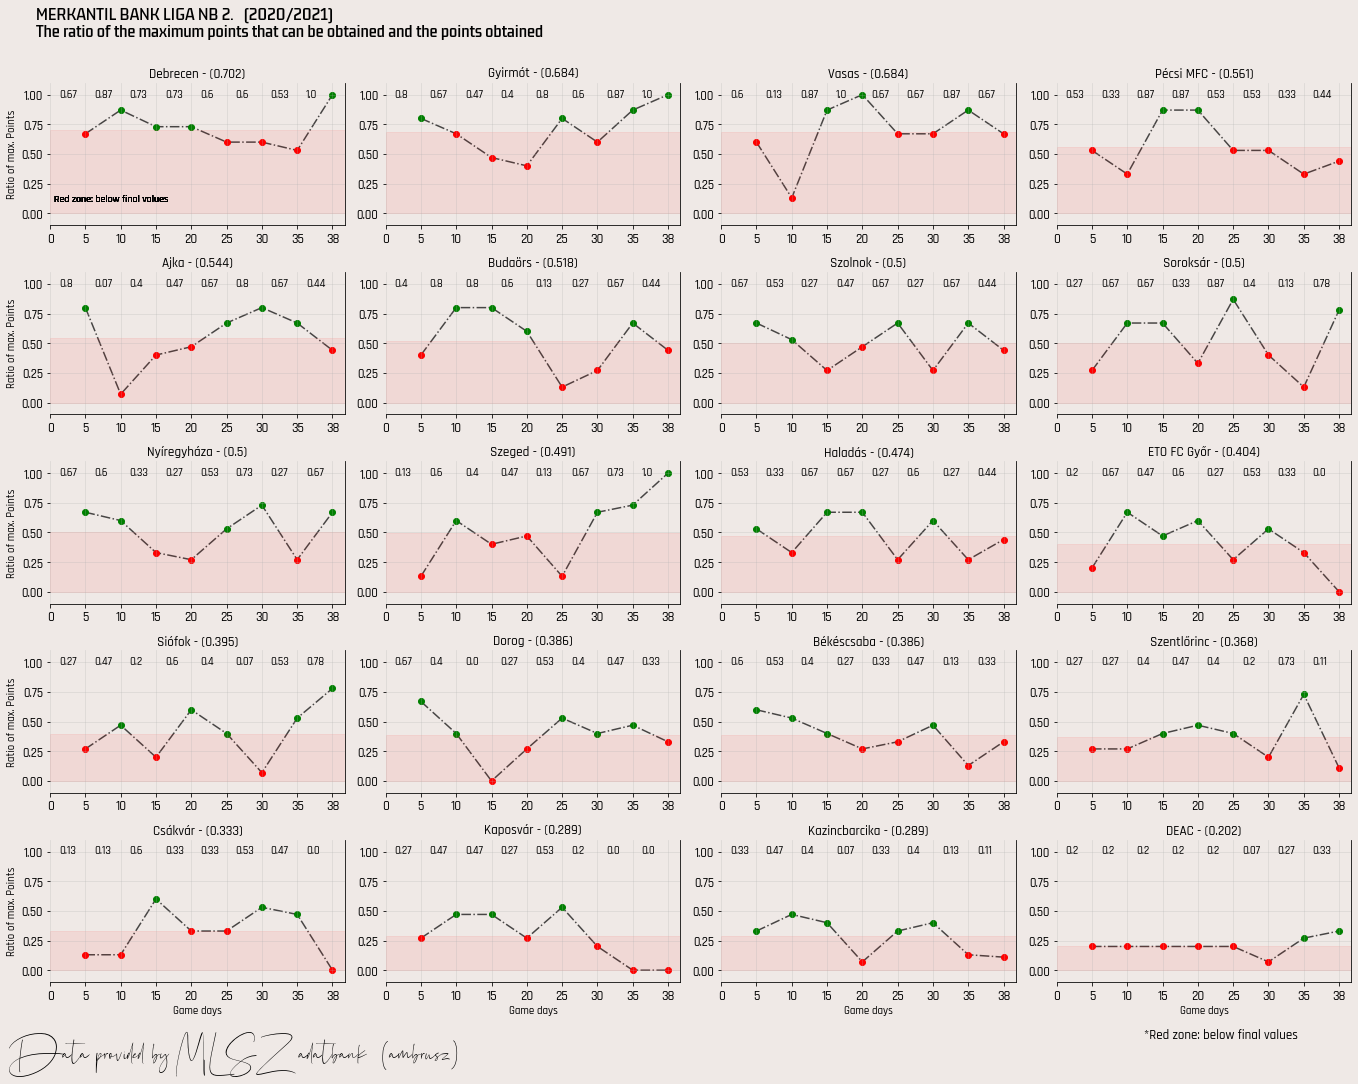

In [45]:
ploTTing(df)

In [71]:
def defineUtils_then_Plot(dataFrame,tM): #  tM=> list of  name of teams
    
    fig = plt.figure()
    fig.set_figheight(13.5)
    fig.set_figwidth(19)
    
    #we make some aesthetic adjustments that we like
    plt.rcParams['axes.facecolor'] = '#FFFFFF'
    plt.rcParams['figure.facecolor'] ='#FFFFFF'
    signature = 'Canonatia'
    
    #you need this to define Plot locations
    counter = 0
    counter2 = 0
    
    
    for ind in range(20):

        num = plt.subplot2grid(shape=(5, 4), loc=(counter, counter2), colspan=1, rowspan=1)


        #to extract the necessary data
        df2 = dataFrame[(dataFrame.HT == tM[ind])|(dataFrame.AT == tM[ind])].reset_index(drop=True)
        df2['Pontjai'] = [df2.iloc[x].hp if  df2.iloc[x].HT == tM[ind] else df2.iloc[x].ap for x in range(len(df2))]
        df2['pct'] = np.where(df2.Pontjai==3,100,np.where(df2.Pontjai == 0,0,33))
        df2['util'] = np.where(df2.Pontjai==3,1,np.where(df2.Pontjai == 0,-2,0))


        #total per 5 rounds
        bPct_5 = [sum(df2.iloc[:x+5].pct) for x in range(0,len(df2),5)]
        bUtil_5 = [sum(df2.iloc[:x+5].util) for x in range(0,len(df2),5)]
        bPont_5 = [sum(df2.iloc[:x+5].Pontjai) for x in range(0,len(df2),5)]
        
        
        xx = [x for x in range(8)]
        
        num.set_xlim(0,9)
        
        num.plot(xx,bUtil_5,ls='-.',color='k',alpha=0.7,zorder=0)
        num.scatter(xx,bUtil_5,c='gray')

        num.set_title(f'{tM[ind]}', fontfamily='Rajdhani',size=13)

        num.grid(axis='both', alpha=0.3,zorder=1)
        num.axhline(0,0,38, ls=':',c='g',alpha=0.8, )
        
        sp = ['top','left']
        for spine in sp:
                num.spines[spine].set_visible(False)

        if ind > 15:
            num.set_xlabel('Game days')

        if ind%4 ==  0:
            num.set_ylabel('Happiness')

        if counter2==0:
            counter2=1
            continue
        if counter2 == 1:
            counter2 =2
            continue
        if counter2 == 2:
            counter2 =3
            continue
        if counter2 == 3:
            counter2 =0
            counter+=1


    fig.tight_layout()
    fig.text(0.01,-0.04,"Data provided by MLSZ adatbank  (ambrusz)" ,fontfamily = signature, fontstyle= 'italic', size= 47)
    fig.text (0.03,1.019, 'MERKANTIL BANK LIGA NB 2.   (2020/2021) \nUtil happiness based on Loss Aversion      (from "Prospect Theory" by Kahneman & Tversky)',size = 14.5, fontfamily = 'Kdam Thmor Pro')
    fig.text(0.84,-0.012,"*Green line - neutral state" ,fontfamily = 'Rajdhani', size= 15)
    #plt.savefig('/Users/arpadambrusz/Desktop/2020_21Season_UTIL_Team.png',dpi=200, bbox_inches="tight");

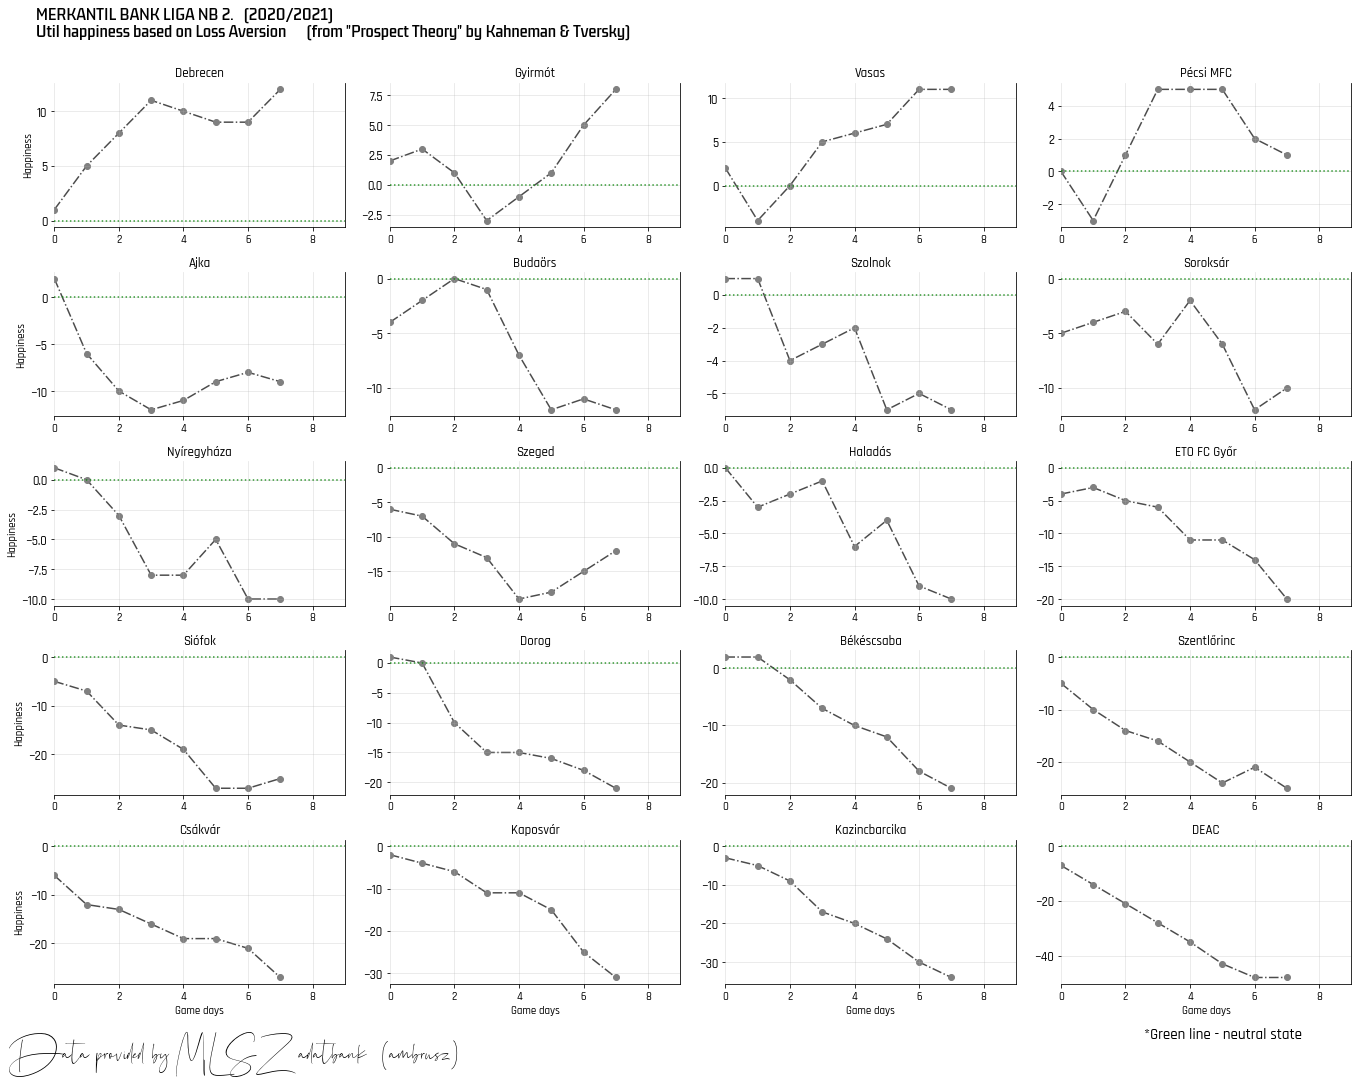

In [72]:
defineUtils_then_Plot(df2021,tt)